<a href="https://colab.research.google.com/github/hunkim98/earth_science/blob/main/lecture/EPS210_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Harvard EPS-210 AI for Earth and Planetary Science

Instructor: Mostafa Mouasvi

# **Lab 3**: Traditional Machine Learnig - Unsupervised Methods

  * **Activity 1**: Earthquake Clustering with K-Means and DBSCAN (5 Parts, 25 Minutes)
  * **Activity 2**: Gaussian Mixture Models for Soft Clustering (2 Parts, 10 Minutes)
  * **Activity 3**: Hierarchical Clustering (2 Parts, 10 Minutes)
  * **Activity 4**: Dimensionality Reduction with Hyperspectral Data (4 Parts, 10 Minutes)
  * **Activity 5**: Synthesis Challenge (Bonus)


---



## Learning Objectives

By the end of this lab, you will be able to:

  * Apply K-Means, DBSCAN, and GMM clustering to earthquake catalog data

  * Use the elbow method and silhouette analysis to select optimal cluster numbers

  * Perform PCA on hyperspectral remote sensing data for dimensionality reduction

  * Visualize high-dimensional data using t-SNE and UMAP

  * Compare clustering methods and understand their trade-offs for geoscience applications



In [ ]:
# Required packages - run this cell first
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Optional but recommended
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    print("UMAP not installed. Run: pip install umap-learn")
    UMAP_AVAILABLE = False

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

______

## **Activity 1**: Earthquake Clustering with K-Means and DBSCAN (5 Parts, 25 Minutes)

## Part 1: Load and Explore Earthquake Data

For this lab, we'll create a realistic synthetic dataset based on real patterns

In practice, you can download real data from: https://earthquake.usgs.gov/earthquakes/search/


In [ ]:
def generate_earthquake_catalog(n_events=1500):
    """
    Generate synthetic earthquake catalog mimicking real patterns:
    - Main fault zone (linear feature)
    - Aftershock cluster
    - Background seismicity (noise)
    """
    np.random.seed(42)

    # Main fault zone - linear feature (like San Andreas)
    n_fault = 600
    fault_lat = np.linspace(35.5, 37.5, n_fault) + np.random.normal(0, 0.05, n_fault)
    fault_lon = np.linspace(-121.5, -119.5, n_fault) + np.random.normal(0, 0.03, n_fault)
    fault_depth = np.random.exponential(8, n_fault) + 2
    fault_mag = np.random.exponential(1.2, n_fault) + 1.5

    # Aftershock cluster (compact region following mainshock)
    n_aftershock = 400
    aftershock_lat = np.random.normal(36.2, 0.15, n_aftershock)
    aftershock_lon = np.random.normal(-120.5, 0.12, n_aftershock)
    aftershock_depth = np.random.exponential(5, n_aftershock) + 3
    aftershock_mag = np.random.exponential(0.8, n_aftershock) + 1.0

    # Secondary cluster (different tectonic feature)
    n_secondary = 300
    secondary_lat = np.random.normal(36.8, 0.2, n_secondary)
    secondary_lon = np.random.normal(-119.2, 0.18, n_secondary)
    secondary_depth = np.random.exponential(12, n_secondary) + 5
    secondary_mag = np.random.exponential(1.0, n_secondary) + 1.2

    # Background seismicity (scattered noise)
    n_background = 200
    background_lat = np.random.uniform(35.0, 38.0, n_background)
    background_lon = np.random.uniform(-122.0, -118.5, n_background)
    background_depth = np.random.exponential(15, n_background) + 1
    background_mag = np.random.exponential(0.9, n_background) + 0.5

    # Combine all events
    df = pd.DataFrame({
        'latitude': np.concatenate([fault_lat, aftershock_lat, secondary_lat, background_lat]),
        'longitude': np.concatenate([fault_lon, aftershock_lon, secondary_lon, background_lon]),
        'depth_km': np.concatenate([fault_depth, aftershock_depth, secondary_depth, background_depth]),
        'magnitude': np.concatenate([fault_mag, aftershock_mag, secondary_mag, background_mag]),
        'true_label': np.concatenate([
            np.zeros(n_fault),          # Fault zone
            np.ones(n_aftershock),      # Aftershock cluster
            np.full(n_secondary, 2),    # Secondary cluster
            np.full(n_background, -1)   # Background (noise)
        ])
    })

    return df

# Generate the earthquake catalog
eq_data = generate_earthquake_catalog()
print(f"Earthquake catalog: {len(eq_data)} events")
print(eq_data.describe())

Earthquake catalog: 1500 events
          latitude    longitude     depth_km    magnitude   true_label
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000
mean     36.475993  -120.210417    11.668203     2.154532     0.533333
std       0.535947     0.739527    10.446878     1.102327     0.957166
min      35.021275  -121.986286     1.110775     0.505294    -1.000000
25%      36.113866  -120.641494     5.097124     1.457594     0.000000
50%      36.418252  -120.397221     8.563736     1.886593     0.000000
75%      36.860636  -119.572424    14.298650     2.595096     1.000000
max      37.964042  -118.501888    87.401885     8.854588     2.000000


## Part 2: Visualize the Raw Data


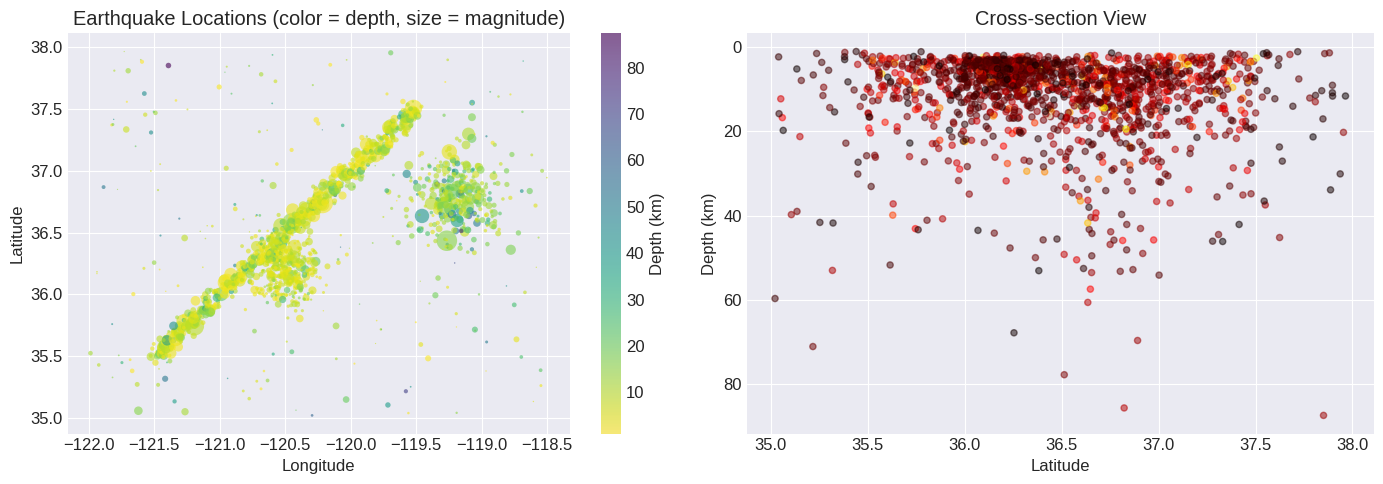

In [ ]:
# Plot the earthquake locations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Map view
scatter = axes[0].scatter(eq_data['longitude'], eq_data['latitude'],
                          c=eq_data['depth_km'], s=eq_data['magnitude']**2 * 3,
                          cmap='viridis_r', alpha=0.6, edgecolors='none')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Earthquake Locations (color = depth, size = magnitude)')
plt.colorbar(scatter, ax=axes[0], label='Depth (km)')

# Depth vs Latitude
axes[1].scatter(eq_data['latitude'], eq_data['depth_km'],
                c=eq_data['magnitude'], s=20, cmap='hot', alpha=0.5)
axes[1].set_xlabel('Latitude')
axes[1].set_ylabel('Depth (km)')
axes[1].set_title('Cross-section View')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Part 3: K-Means Clustering

Task: Apply K-Means to identify earthquake clusters. Remember from lecture that K-Means assumes spherical clusters!

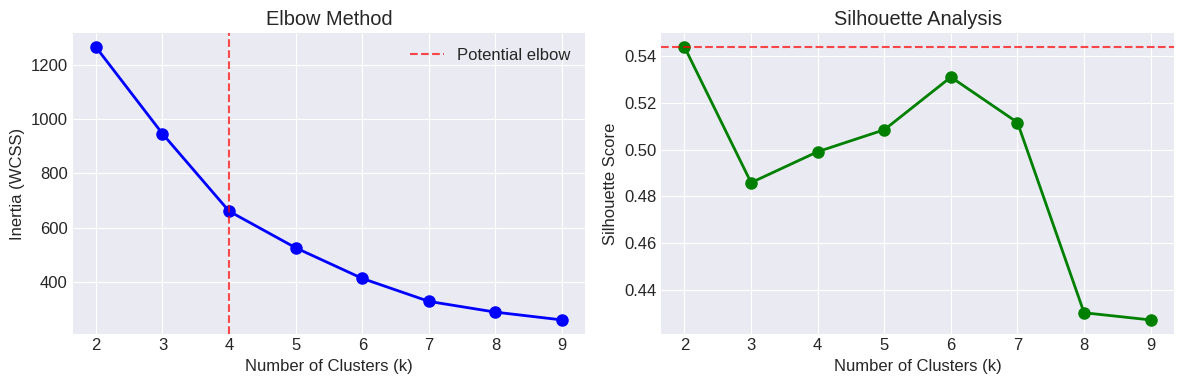

Best silhouette score: 0.544 at k=2


In [ ]:
# Prepare features for clustering (location only first)
X_spatial = eq_data[['longitude', 'latitude']].values

# Standardize features (CRITICAL for distance-based methods)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_spatial)

# Apply K-Means with different k values
k_range = range(2, 10)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Plot elbow and silhouette
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (WCSS)')
axes[0].set_title('Elbow Method')
axes[0].axvline(x=4, color='r', linestyle='--', alpha=0.7, label='Potential elbow')
axes[0].legend()

axes[1].plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].axhline(y=max(silhouettes), color='r', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Best silhouette score: {max(silhouettes):.3f} at k={k_range[np.argmax(silhouettes)]}")

✏️ Exercise 1.1: Optimal K Selection

Based on the elbow plot and silhouette analysis:

What value of k would you choose? Why?

Does the elbow method give a clear answer?

What does a low silhouette score suggest about the data?



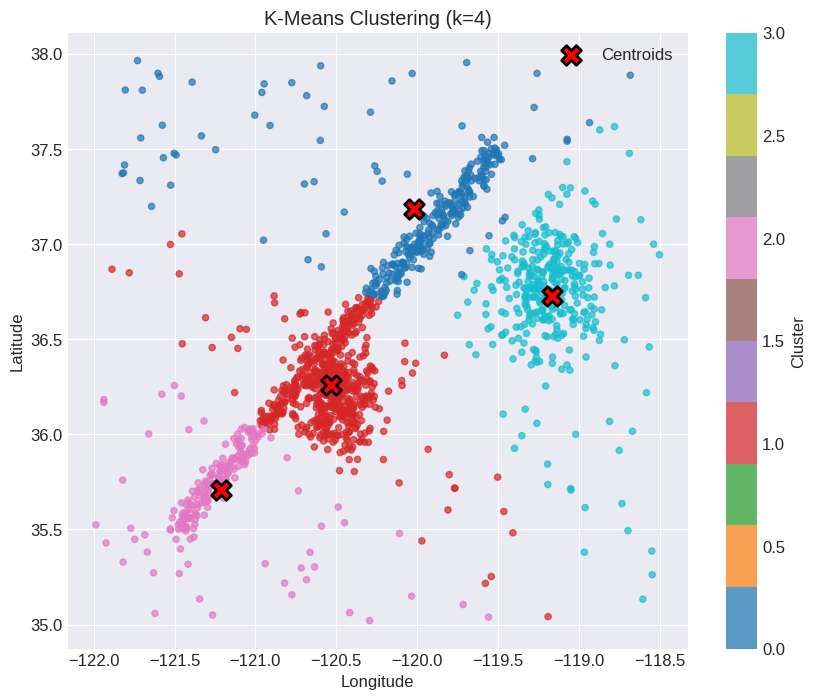

In [ ]:
# YOUR CODE: Run K-Means with your chosen k
# Based on elbow plot and silhouette analysis, choose optimal k
# EXERCISE: Change this value based on your analysis!
optimal_k = 4  # <-- Modify this based on your elbow/silhouette analysis

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Visualize results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(eq_data['longitude'], eq_data['latitude'],
                      c=kmeans_labels, cmap='tab10', s=20, alpha=0.7)
plt.scatter(scaler.inverse_transform(kmeans_final.cluster_centers_)[:, 0],
            scaler.inverse_transform(kmeans_final.cluster_centers_)[:, 1],
            c='red', marker='X', s=200, edgecolors='black', linewidths=2,
            label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()

## Part 4: DBSCAN: Density-Based Clustering

From lecture: DBSCAN excels at finding arbitrary shapes and identifying noise. This is ideal for fault lines!

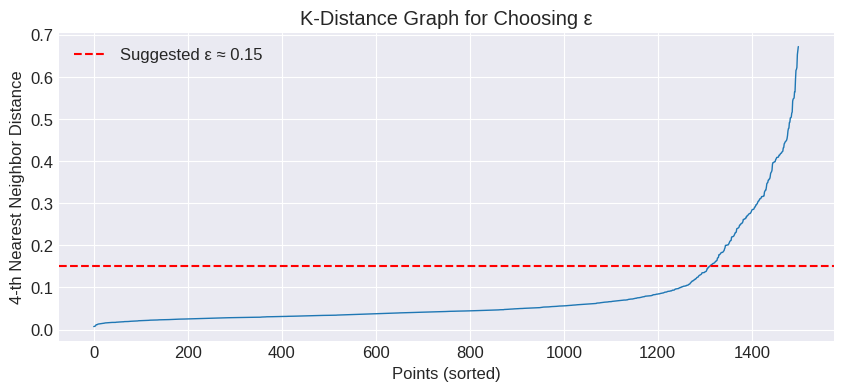

In [ ]:
# K-distance plot to find optimal epsilon
from sklearn.neighbors import NearestNeighbors

k = 4  # MinPts - 1 (rule of thumb: dimensions + 1)
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_scaled)
distances, _ = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 4))
plt.plot(distances, linewidth=1)
plt.xlabel('Points (sorted)')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title('K-Distance Graph for Choosing ε')
plt.axhline(y=0.15, color='r', linestyle='--', label='Suggested ε ≈ 0.15')
plt.legend()
plt.show()

✏️ Exercise 1.2: DBSCAN Parameter Tuning


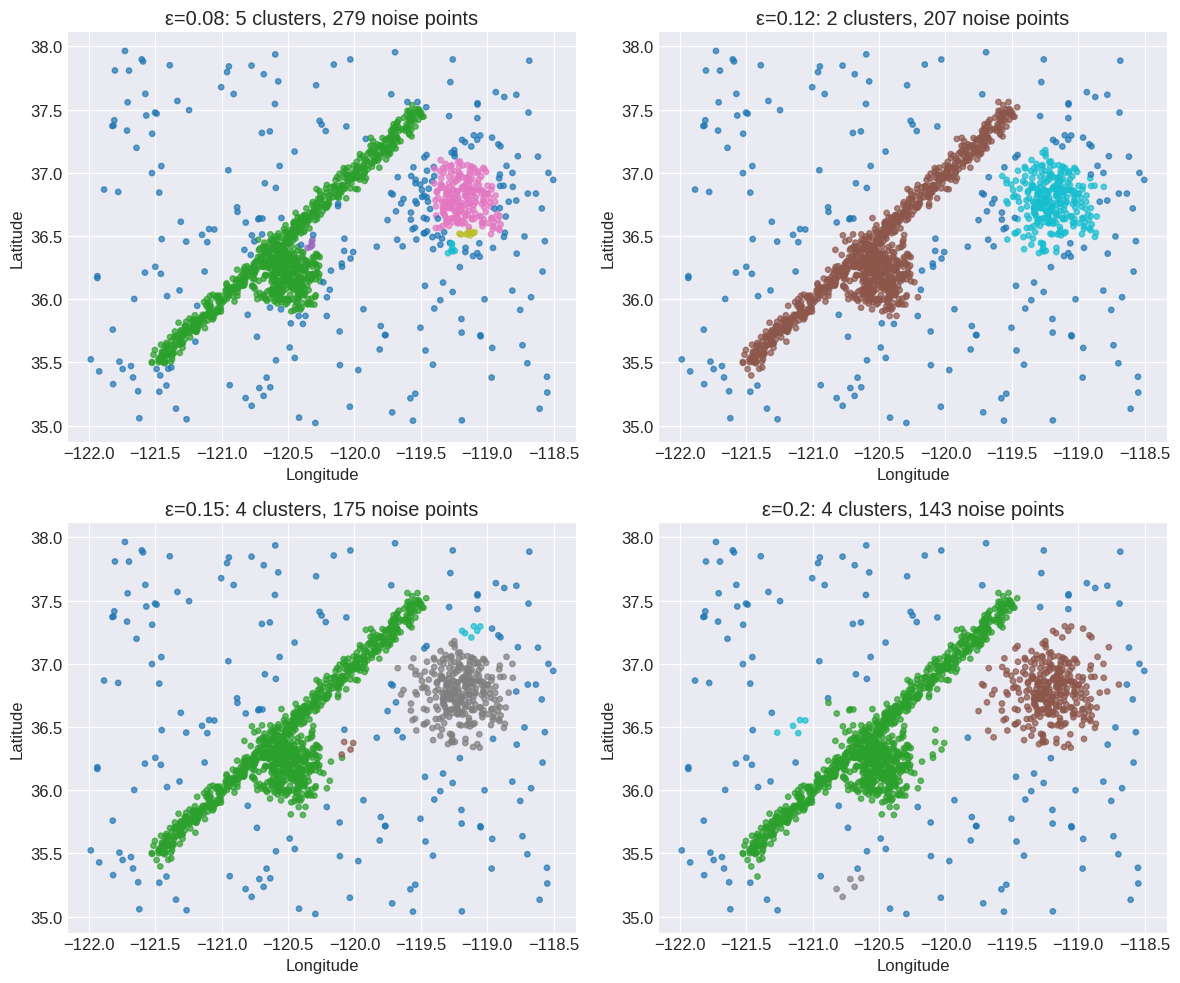

In [ ]:
# Experiment with different eps values
eps_values = [0.08, 0.12, 0.15, 0.20]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, eps in enumerate(eps_values):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # Plot
    scatter = axes[idx].scatter(eq_data['longitude'], eq_data['latitude'],
                                c=labels, cmap='tab10', s=15, alpha=0.7)
    axes[idx].set_title(f'ε={eps}: {n_clusters} clusters, {n_noise} noise points')
    axes[idx].set_xlabel('Longitude')
    axes[idx].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

# Questions to answer:
# 1. Which eps value best identifies the fault line as a single cluster?
# 2. How does DBSCAN handle the scattered background seismicity?
# 3. Compare the noise detection between different eps values.

## Part 5: Comparing K-Means vs DBSCAN


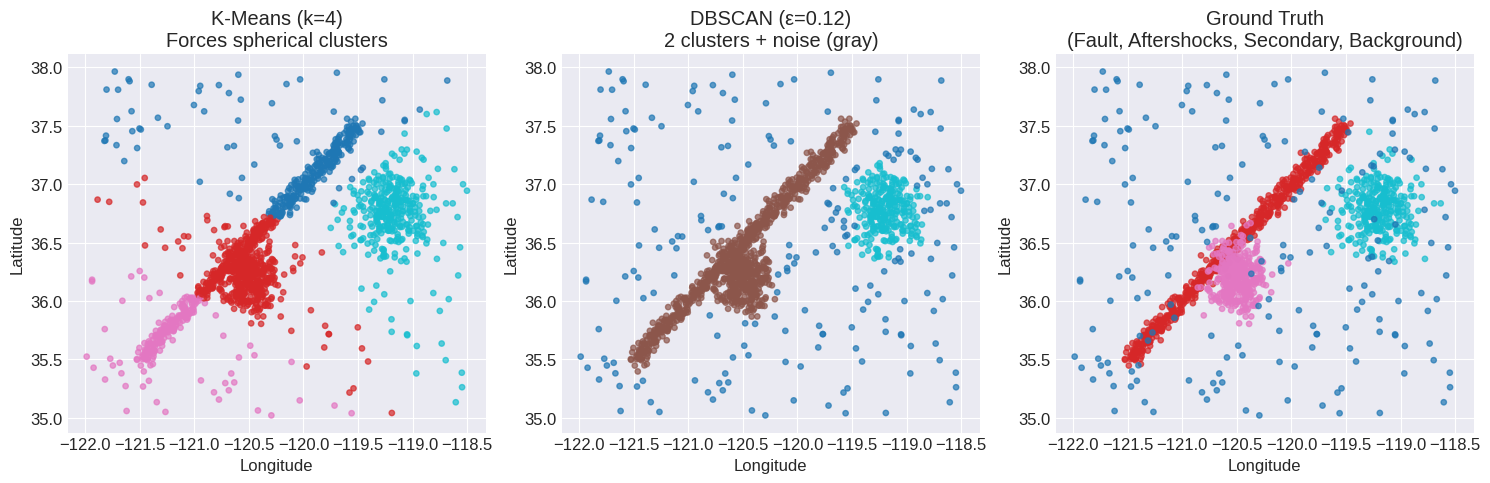


🔍 KEY INSIGHT from lecture:
K-Means assumes spherical clusters → fails on linear fault zones
DBSCAN uses local density → can detect arbitrary shapes + noise


In [ ]:
# Best DBSCAN result
dbscan_best = DBSCAN(eps=0.12, min_samples=5)
dbscan_labels = dbscan_best.fit_predict(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# K-Means
axes[0].scatter(eq_data['longitude'], eq_data['latitude'],
                c=kmeans_labels, cmap='tab10', s=15, alpha=0.7)
axes[0].set_title(f'K-Means (k={optimal_k})\nForces spherical clusters')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# DBSCAN
axes[1].scatter(eq_data['longitude'], eq_data['latitude'],
                c=dbscan_labels, cmap='tab10', s=15, alpha=0.7)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
axes[1].set_title(f'DBSCAN (ε=0.12)\n{n_clusters} clusters + noise (gray)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Ground truth
axes[2].scatter(eq_data['longitude'], eq_data['latitude'],
                c=eq_data['true_label'], cmap='tab10', s=15, alpha=0.7)
axes[2].set_title('Ground Truth\n(Fault, Aftershocks, Secondary, Background)')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

print("\n🔍 KEY INSIGHT from lecture:")
print("K-Means assumes spherical clusters → fails on linear fault zones")
print("DBSCAN uses local density → can detect arbitrary shapes + noise")

______

## **Activity 2**: Gaussian Mixture Models for Soft Clustering (2 Parts, 10 Minutes)

## Part 1: Probabilistic Cluster Assignments

From lecture: GMM provides soft assignments - each point has a probability of belonging to each cluster.

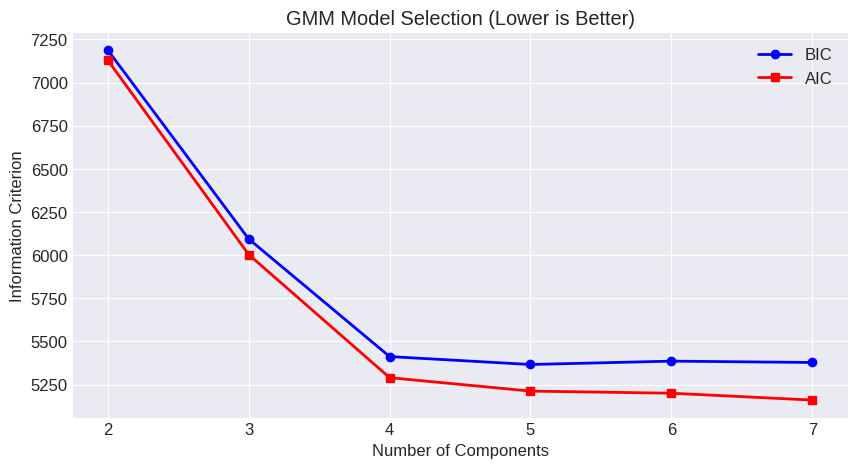

Optimal number of components (BIC): 5


In [ ]:
# Fit GMM with different numbers of components
n_components_range = range(2, 8)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=5)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

# Plot model selection criteria
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(n_components_range, bic_scores, 'bo-', label='BIC', linewidth=2)
ax.plot(n_components_range, aic_scores, 'rs-', label='AIC', linewidth=2)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Information Criterion')
ax.set_title('GMM Model Selection (Lower is Better)')
ax.legend()
plt.show()

optimal_gmm_n = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components (BIC): {optimal_gmm_n}")

## Part 2: Visualizing Soft Assignments


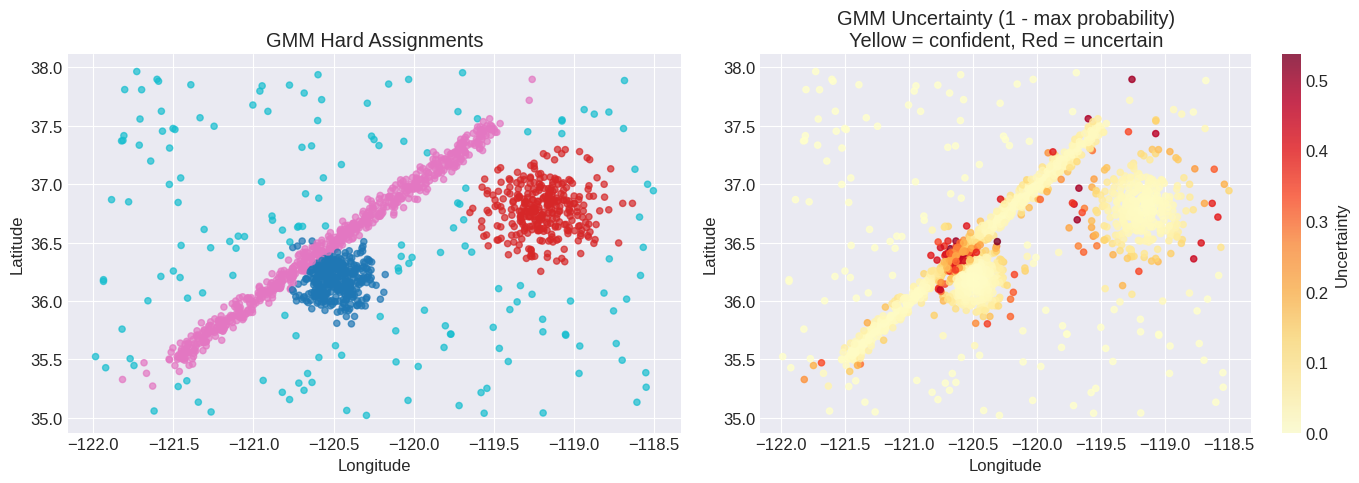


📊 Example soft assignments (first 5 events):
Event | Prob(C0) | Prob(C1) | Prob(C2) | Prob(C3) | Assigned
------------------------------------------------------------
  0   | 0.000 | 0.000 | 0.988 | 0.012 |    2
  1   | 0.000 | 0.000 | 0.987 | 0.013 |    2
  2   | 0.000 | 0.000 | 0.988 | 0.012 |    2
  3   | 0.000 | 0.000 | 0.985 | 0.015 |    2
  4   | 0.000 | 0.000 | 0.987 | 0.013 |    2


In [ ]:
# Fit optimal GMM
gmm = GaussianMixture(n_components=4, random_state=42, n_init=5, covariance_type='full')
gmm.fit(X_scaled)

# Get hard and soft predictions
gmm_labels = gmm.predict(X_scaled)
gmm_probs = gmm.predict_proba(X_scaled)

# Calculate uncertainty (1 - max probability)
uncertainty = 1 - gmm_probs.max(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hard assignments
axes[0].scatter(eq_data['longitude'], eq_data['latitude'],
                c=gmm_labels, cmap='tab10', s=20, alpha=0.7)
axes[0].set_title('GMM Hard Assignments')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Uncertainty map
scatter = axes[1].scatter(eq_data['longitude'], eq_data['latitude'],
                          c=uncertainty, cmap='YlOrRd', s=20, alpha=0.8)
axes[1].set_title('GMM Uncertainty (1 - max probability)\nYellow = confident, Red = uncertain')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(scatter, ax=axes[1], label='Uncertainty')

plt.tight_layout()
plt.show()

# Show example of soft assignments
print("\n📊 Example soft assignments (first 5 events):")
print("Event | Prob(C0) | Prob(C1) | Prob(C2) | Prob(C3) | Assigned")
print("-" * 60)
for i in range(5):
    probs_str = " | ".join([f"{p:.3f}" for p in gmm_probs[i]])
    print(f"  {i}   | {probs_str} |    {gmm_labels[i]}")

✏️ Exercise 2.1: Interpretation Questions

* Where are the most uncertain points located? Why does this make geological sense?

* Compare the GMM ellipses to K-Means spheres - which better captures the fault geometry?

* When would you prefer soft assignments over hard assignments in seismology?

________________

## **Activity 3**: Hierarchical Clustering (2 Parts, 10 Minutes)

## Part 1: Building a Dendrogram

From lecture: Hierarchical clustering reveals nested structure - cut at different heights for different granularities.

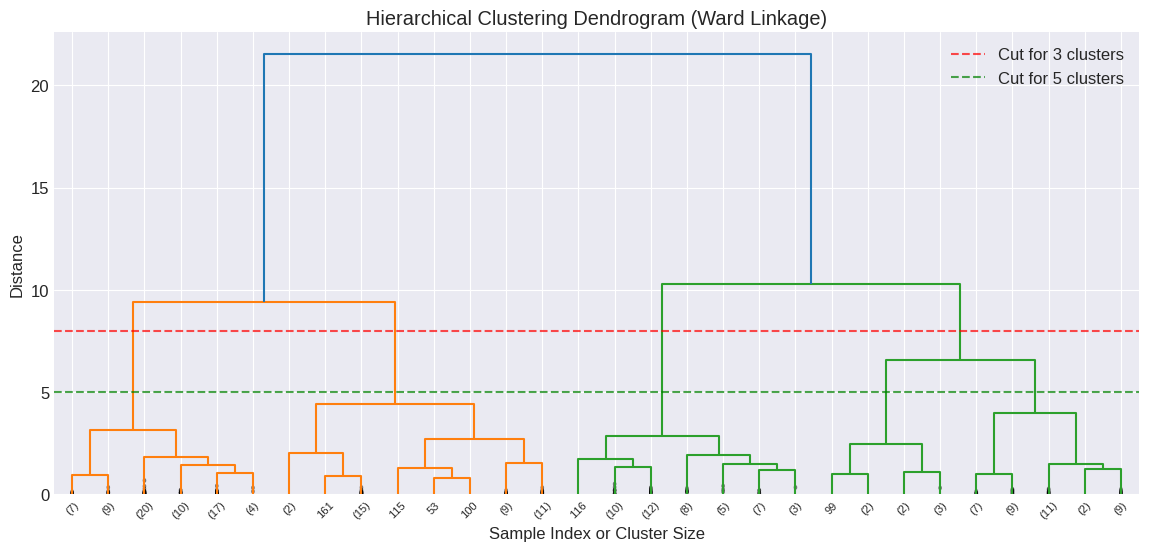

In [ ]:
# Use a subset for visualization (dendrograms get cluttered with many points)
subset_idx = np.random.choice(len(X_scaled), size=200, replace=False)
X_subset = X_scaled[subset_idx]

# Compute linkage matrix
linkage_matrix = linkage(X_subset, method='ward')

# Plot dendrogram
fig, ax = plt.subplots(figsize=(14, 6))
dendrogram(linkage_matrix, ax=ax, truncate_mode='lastp', p=30,
           leaf_font_size=8, show_contracted=True)
ax.set_title('Hierarchical Clustering Dendrogram (Ward Linkage)')
ax.set_xlabel('Sample Index or Cluster Size')
ax.set_ylabel('Distance')

# Add horizontal lines for potential cuts
ax.axhline(y=8, color='r', linestyle='--', alpha=0.7, label='Cut for 3 clusters')
ax.axhline(y=5, color='g', linestyle='--', alpha=0.7, label='Cut for 5 clusters')
ax.legend()
plt.show()

## Part 2: Comparing Linkage Methods


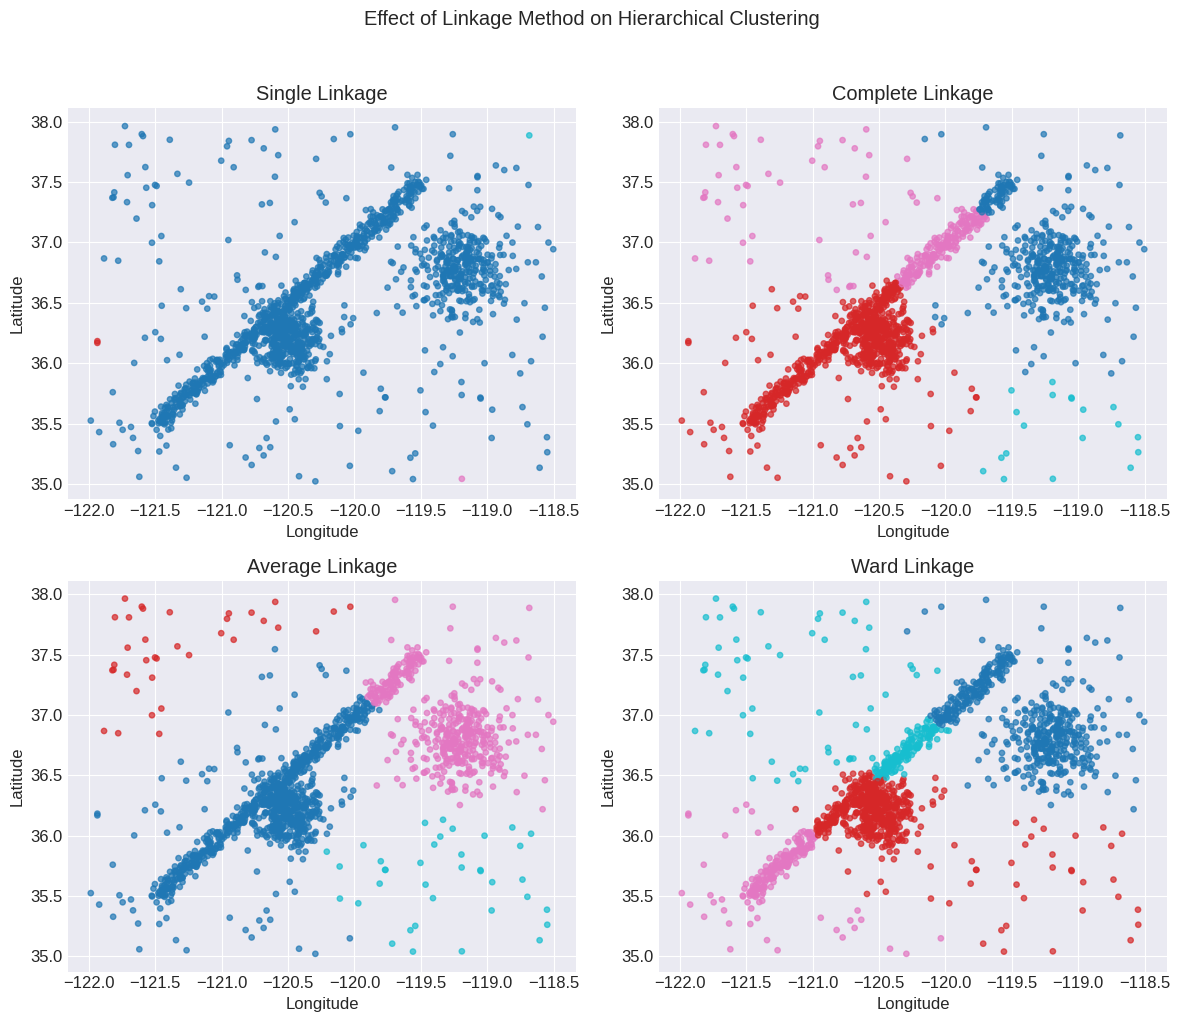


📝 Linkage methods (from lecture):
• Single: Minimum distance → creates chains (good for elongated clusters)
• Complete: Maximum distance → compact clusters
• Average: Mean distance → balanced approach
• Ward: Minimize variance increase → similar to K-Means


In [ ]:
# Compare different linkage methods
methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, method in enumerate(methods):
    agg = AgglomerativeClustering(n_clusters=4, linkage=method)
    labels = agg.fit_predict(X_scaled)

    axes[idx].scatter(eq_data['longitude'], eq_data['latitude'],
                      c=labels, cmap='tab10', s=15, alpha=0.7)
    axes[idx].set_title(f'{method.capitalize()} Linkage')
    axes[idx].set_xlabel('Longitude')
    axes[idx].set_ylabel('Latitude')

plt.suptitle('Effect of Linkage Method on Hierarchical Clustering', y=1.02)
plt.tight_layout()
plt.show()

print("\n📝 Linkage methods (from lecture):")
print("• Single: Minimum distance → creates chains (good for elongated clusters)")
print("• Complete: Maximum distance → compact clusters")
print("• Average: Mean distance → balanced approach")
print("• Ward: Minimize variance increase → similar to K-Means")

_______________

## **Activity 4**: Dimensionality Reduction with Hyperspectral Data (4 Parts, 10 Minutes)

## Part 1: Load Simulated Hyperspectral Data

We'll simulate data similar to the Indian Pines hyperspectral dataset (200+
spectral bands, multiple land cover classes).

Hyperspectral data: 996 samples × 100 bands
Classes: ['Vegetation', 'Bare Soil', 'Water', 'Urban', 'Rock_A', 'Rock_B']


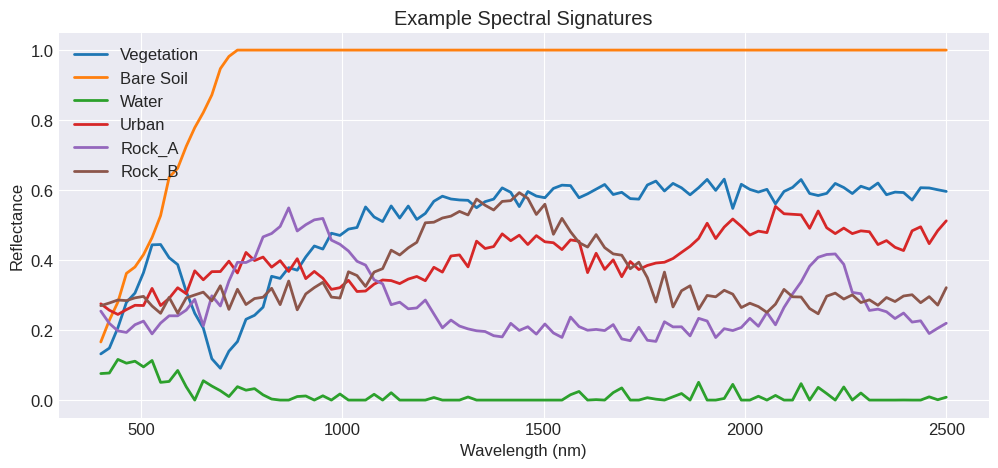

In [ ]:
def generate_hyperspectral_data(n_samples=1000, n_bands=100, n_classes=6):
    """
    Generate synthetic hyperspectral-like data with distinct spectral signatures.
    Simulates mineral/vegetation spectral libraries.
    """
    np.random.seed(42)

    # Define base spectral signatures for each class
    wavelengths = np.linspace(400, 2500, n_bands)  # nm

    class_signatures = {
        'Vegetation': lambda w: 0.1 + 0.4 * np.exp(-((w-550)/100)**2) + 0.6 * (w > 700) * (1 - np.exp(-(w-700)/200)),
        'Bare Soil': lambda w: 0.15 + 0.002 * (w - 400),
        'Water': lambda w: 0.1 * np.exp(-((w-480)/150)**2),
        'Urban': lambda w: 0.3 + 0.0001 * (w - 400) + 0.05 * np.sin(w/100),
        'Rock_A': lambda w: 0.2 + 0.3 * np.exp(-((w-900)/200)**2) + 0.2 * np.exp(-((w-2200)/100)**2),
        'Rock_B': lambda w: 0.25 + 0.25 * np.exp(-((w-1400)/300)**2)
    }

    class_names = list(class_signatures.keys())
    samples_per_class = n_samples // n_classes

    X = []
    y = []

    for class_idx, (class_name, signature_fn) in enumerate(class_signatures.items()):
        base_spectrum = signature_fn(wavelengths)

        for _ in range(samples_per_class):
            # Add realistic noise and variation
            noise = np.random.normal(0, 0.02, n_bands)
            variation = np.random.normal(1, 0.1) * base_spectrum
            spectrum = np.clip(variation + noise, 0, 1)
            X.append(spectrum)
            y.append(class_idx)

    return np.array(X), np.array(y), wavelengths, class_names

# Generate data
X_hyper, y_hyper, wavelengths, class_names = generate_hyperspectral_data()
print(f"Hyperspectral data: {X_hyper.shape[0]} samples × {X_hyper.shape[1]} bands")
print(f"Classes: {class_names}")

# Plot example spectra
fig, ax = plt.subplots(figsize=(12, 5))
for class_idx in range(len(class_names)):
    idx = np.where(y_hyper == class_idx)[0][0]
    ax.plot(wavelengths, X_hyper[idx], label=class_names[class_idx], linewidth=2)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Reflectance')
ax.set_title('Example Spectral Signatures')
ax.legend()
plt.show()

## Part 2: PCA for Dimensionality Reduction

From lecture: PCA finds orthogonal directions of maximum variance - the first few PCs often capture >95% of information.


✅ 2 components explain 95% of variance
   (Reduced from 100 bands!)


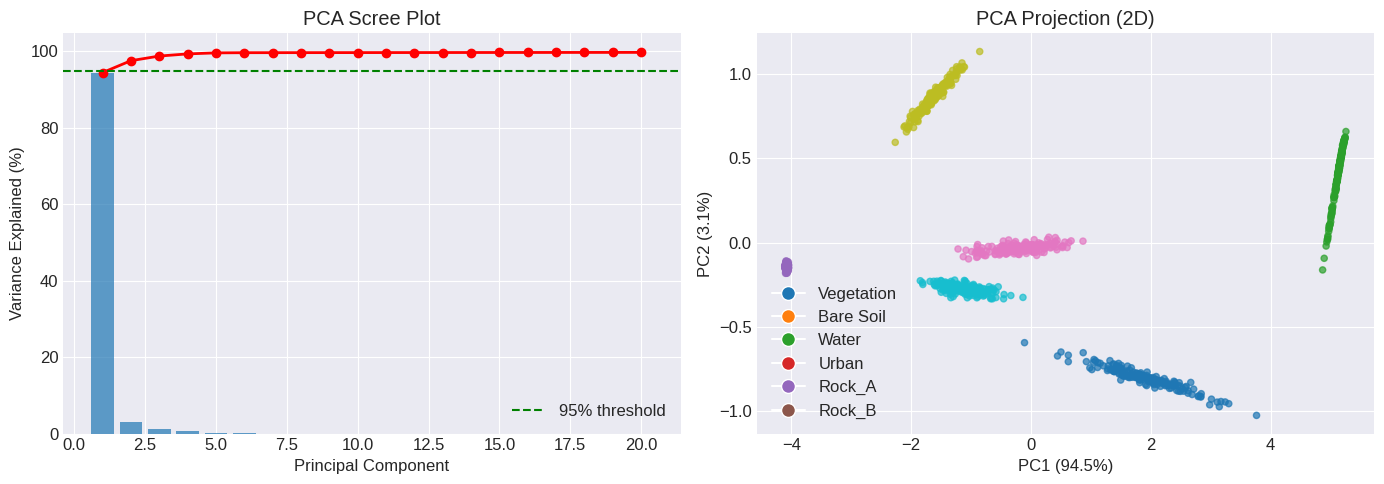

In [ ]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_hyper)

# Explained variance analysis
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, 21), pca.explained_variance_ratio_[:20] * 100, alpha=0.7)
axes[0].plot(range(1, 21), cumulative_variance[:20] * 100, 'ro-', linewidth=2)
axes[0].axhline(y=95, color='g', linestyle='--', label='95% threshold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained (%)')
axes[0].set_title('PCA Scree Plot')
axes[0].legend()

# Find number of PCs for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\n✅ {n_components_95} components explain 95% of variance")
print(f"   (Reduced from {X_hyper.shape[1]} bands!)")

# PC1 vs PC2 scatter
scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_hyper, cmap='tab10',
                          s=20, alpha=0.7)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('PCA Projection (2D)')

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=plt.cm.tab10(i/10), markersize=10, label=name)
           for i, name in enumerate(class_names)]
axes[1].legend(handles=handles, loc='best')

plt.tight_layout()
plt.show()

## Part 3 t-SNE for Visualization

From lecture: t-SNE preserves local neighborhoods - excellent for revealing cluster structure, but beware interpretation pitfalls!

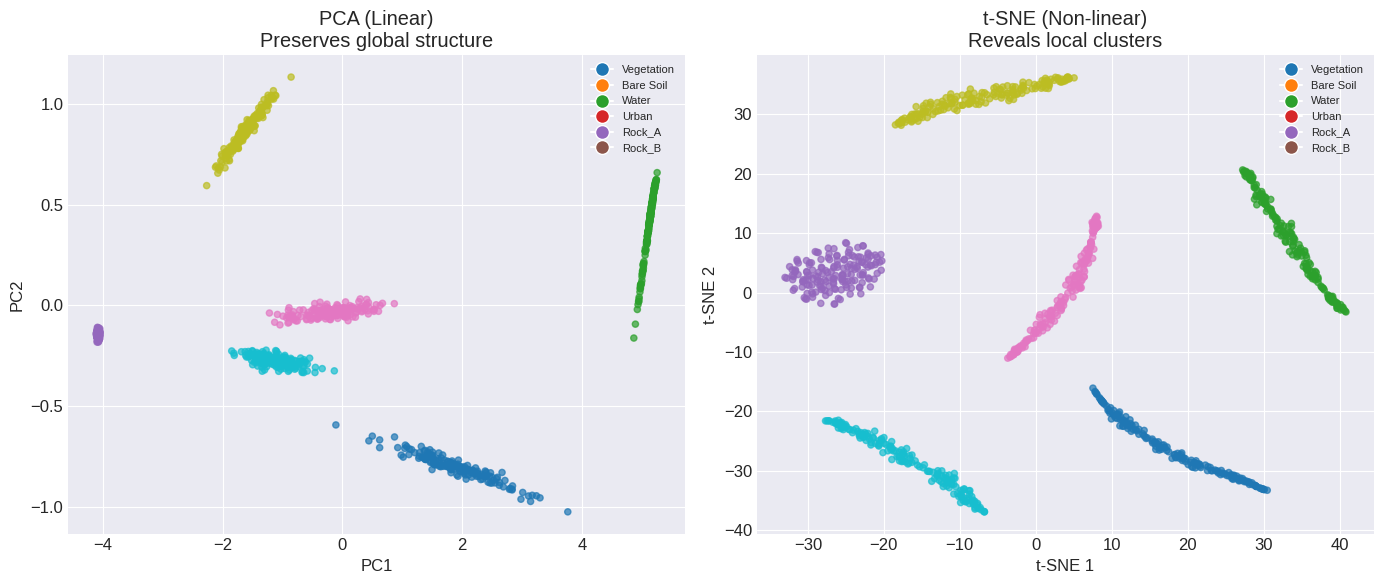


⚠️  t-SNE WARNINGS (from lecture):
• Cluster SIZES don't reflect true sizes
• Distances BETWEEN clusters are not meaningful
• Run multiple times to check stability


In [ ]:
# Apply t-SNE (use PCA-reduced data for speed)
X_pca_reduced = X_pca[:, :20]  # First 20 PCs

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca_reduced)

# Compare PCA vs t-SNE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_hyper, cmap='tab10', s=20, alpha=0.7)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PCA (Linear)\nPreserves global structure')

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_hyper, cmap='tab10', s=20, alpha=0.7)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('t-SNE (Non-linear)\nReveals local clusters')

# Add legends
for ax in axes:
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=plt.cm.tab10(i/10), markersize=10, label=name)
               for i, name in enumerate(class_names)]
    ax.legend(handles=handles, loc='best', fontsize=8)

plt.tight_layout()
plt.show()

print("\n⚠️  t-SNE WARNINGS (from lecture):")
print("• Cluster SIZES don't reflect true sizes")
print("• Distances BETWEEN clusters are not meaningful")
print("• Run multiple times to check stability")

## Part 4: UMAP (Optional)


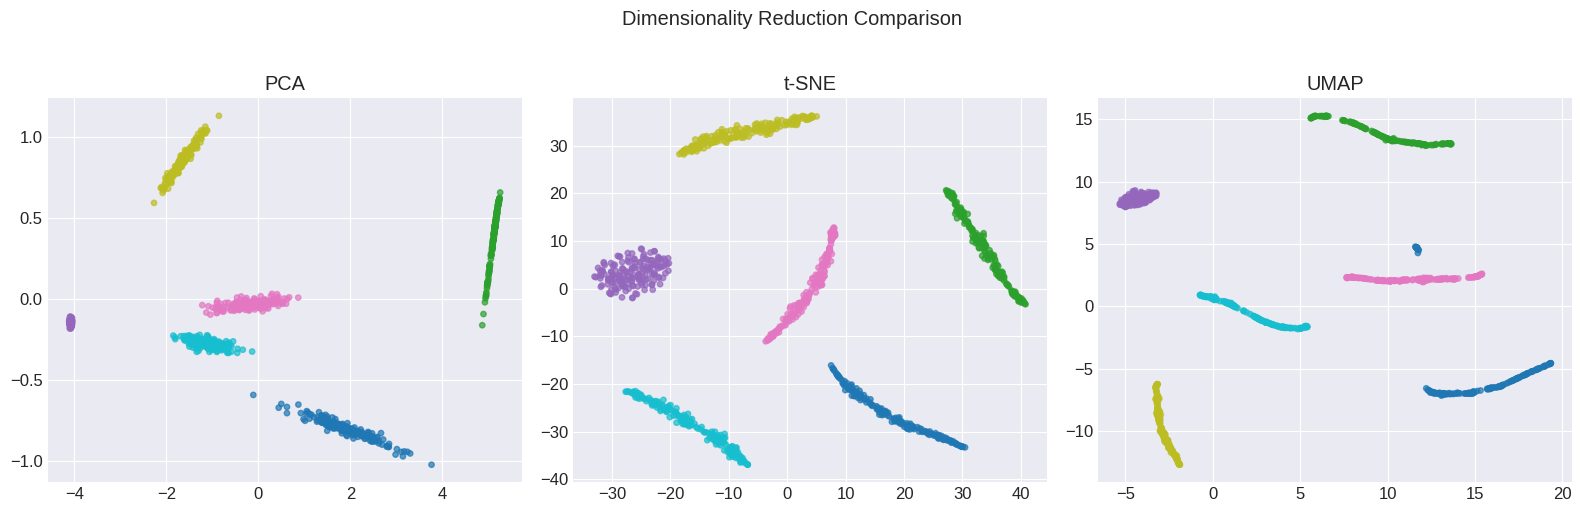


📊 UMAP vs t-SNE (from lecture):
• UMAP is much FASTER
• UMAP preserves GLOBAL structure better
• UMAP can project NEW points


In [ ]:
if UMAP_AVAILABLE:
    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap = reducer.fit_transform(X_pca_reduced)

    # Compare all three methods
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_hyper, cmap='tab10', s=15, alpha=0.7)
    axes[0].set_title('PCA')

    axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_hyper, cmap='tab10', s=15, alpha=0.7)
    axes[1].set_title('t-SNE')

    axes[2].scatter(X_umap[:, 0], X_umap[:, 1], c=y_hyper, cmap='tab10', s=15, alpha=0.7)
    axes[2].set_title('UMAP')

    plt.suptitle('Dimensionality Reduction Comparison', y=1.02)
    plt.tight_layout()
    plt.show()

    print("\n📊 UMAP vs t-SNE (from lecture):")
    print("• UMAP is much FASTER")
    print("• UMAP preserves GLOBAL structure better")
    print("• UMAP can project NEW points")
else:
    print("UMAP not available. Install with: pip install umap-learn")

_______

## **Activity 5**: Synthesis Challenge (Bonus)

Combining Clustering and Dimensionality Reduction

Real-world workflow: Reduce dimensions first, then cluster!

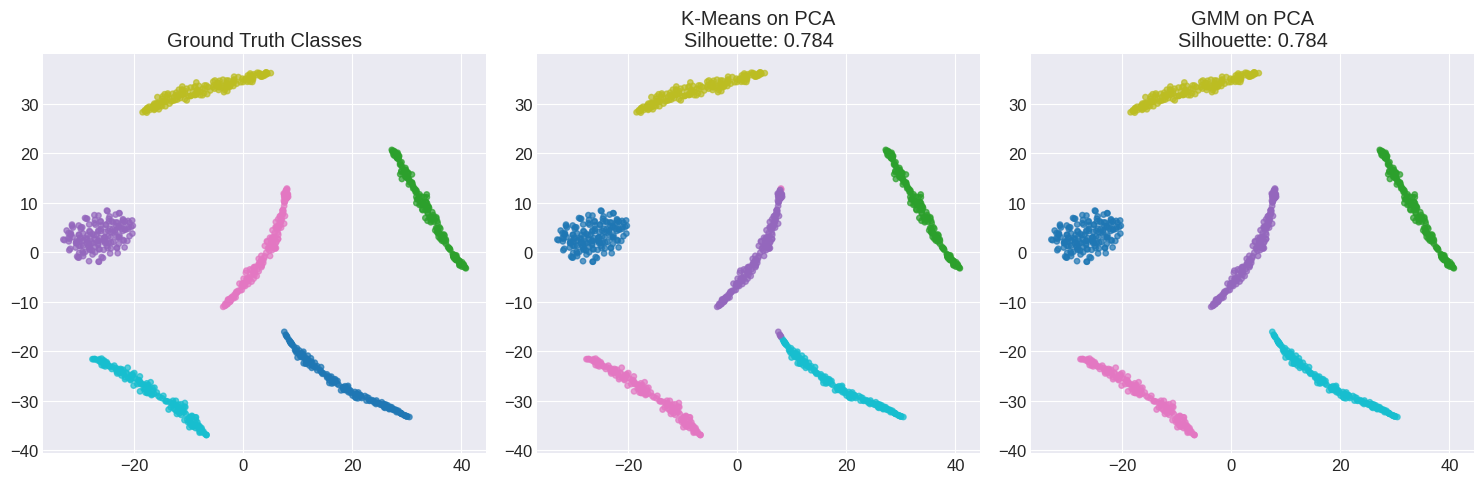

In [ ]:
# Workflow: PCA → UMAP/t-SNE → Clustering
# This addresses DBSCAN's "curse of dimensionality" problem

# Step 1: PCA for noise reduction
pca_denoise = PCA(n_components=10)
X_denoised = pca_denoise.fit_transform(X_hyper)

# Step 2: Apply clustering methods
kmeans_hyper = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_hyper_labels = kmeans_hyper.fit_predict(X_denoised)

gmm_hyper = GaussianMixture(n_components=6, random_state=42)
gmm_hyper_labels = gmm_hyper.fit_predict(X_denoised)

# Step 3: Visualize in 2D (using t-SNE of PCA-reduced data)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# True labels
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_hyper, cmap='tab10', s=15, alpha=0.7)
axes[0].set_title('Ground Truth Classes')

# K-Means on PCA-reduced
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_hyper_labels, cmap='tab10', s=15, alpha=0.7)
axes[1].set_title(f'K-Means on PCA\nSilhouette: {silhouette_score(X_denoised, kmeans_hyper_labels):.3f}')

# GMM on PCA-reduced
axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_hyper_labels, cmap='tab10', s=15, alpha=0.7)
axes[2].set_title(f'GMM on PCA\nSilhouette: {silhouette_score(X_denoised, gmm_hyper_labels):.3f}')

plt.tight_layout()
plt.show()

## Summary: Method Selection Guide

Scenario --> Recommended Method (Why)

Unknown number of clusters, noisy data --> **DBSCAN** (Automatic k, noise detection)

Spherical clusters, fast results needed --> **K-Means** (Simple, scalable)

Need cluster probabilities/uncertainty --> **GMM** (Soft assignments)

Want to see hierarchical structure --> **Agglomerative Dendrogram visualization**

High-dimensional data preprocessing --> **PCA** (Linear, interpretable)

2D visualization of clusters --> **t-SNE** / **UMAP** (Non-linear structure preservation)


## 🏆 Going Further: Real-World Competitions & Data

If you enjoyed this lab, these resources offer "next-level" challenges using the same skills:

1. [**LANL Earthquake Prediction (Kaggle)**](https://www.kaggle.com/c/LANL-Earthquake-Prediction)

The Challenge: Predict the time remaining before a **laboratory** earthquake occurs based on acoustic signal data.

Relevance: This uses the concepts of Dimensionality Reduction (processing high-frequency acoustic waves) and Regression (predicting time).


2. [**NASA EMIT Data (Hyperspectral)**](https://github.com/nasa/EMIT-Data-Resources)

The Challenge: NASA's EMIT mission on the ISS maps surface mineralogy. The data is hyperspectral (hundreds of bands).

Task: Use PCA or UMAP to reduce the 288 spectral bands down to 3 dimensions (RGB) to visualize "hidden" minerals like Kaolinite or Calcite that are invisible to the naked eye.


3. [**Asteroid Classification (Kaggle)**](https://www.kaggle.com/datasets/shrutimehta/nasa-asteroids-classification)

The Challenge: Classify asteroids as hazardous or non-hazardous.

Task: Use the "Orbital Elements" dataset to cluster asteroids and see if "Potentially Hazardous Asteroids" (PHAs) form a distinct cluster in the UMAP space.


_______

# Further Reading & Data Sources**

## Hyperspectral Benchmarks

**Indian Pines:** AVIRIS sensor, 224 bands, agricultural classification
**Pavia University:** ROSIS sensor, 103 bands, urban classification
**Salinas Valley:** AVIRIS sensor, 224 bands, crop classification

## Climate Data

**NOAA ENSO Indices:** psl.noaa.gov/enso/data.html
**Multivariate ENSO Index (MEI):** Perfect for PCA/EOF analysis

## Asteroid Data

**Minor Planet Center:** minorplanetcenter.net/data
**Lowell Observatory astorb:** asteroid.lowell.edu/astorb/

## Real Earthquake Data

The high-resolution earthquake catalog for 2019 Ridgecrest Earthquake Sequence from [Shelly 2020](https://pubs.geoscienceworld.org/ssa/srl/article/91/4/1971/580481/A-High-Resolution-Seismic-Catalog-for-the-Initial) can be a good choice.

You can download earthquake catalogs from [USGS](https://earthquake.usgs.gov/earthquakes/search/), [ISC](https://www.isc.ac.uk/iscbulletin/search/catalogue/#outputlinks), [EMSC](https://www.emsc.eu/).
[libcomcat](https://code.usgs.gov/ghsc/esi/libcomcat-python) is the USGS's official tool for automatic downloading of earthquake catalogs and associated metadata.


In [ ]:
import pandas as pd

url = "https://gsw.silverchair-cdn.com/gsw/Content_public/Journal/srl/91/4/10.1785_0220190309/3/srl-2019309_supplement_hypos_ridgecrest_srl_header_mnew.txt?Expires=1771805020&Signature=g9WLqHaIlFwR9FKlLQ9o-~~PnI9ndYuj2UFN1n54znbgChqFaDrdfVxBel8-oO8Rx0GPNNUEVb8jZ0RsW0X5FTKu65UfR0hbwIAXNrqsOF~nUzjWOaebiAykaXLgotoAV9FMZleLxQzhr5ycenraZFAroZrJpkha1u4qzwQs-8VugujMJjO3Wk4OYY-N0MMdcJydMz6GISB-Ke6e5IDhJfrux-5YhcSPTKuSVZP3XkOye-UnXBnq1sv1A95HgYqpFAwTZYQJGRIcbb3wvHirr7DfolBd5njgENA2kphLWWkV1rr~9Rn6~RA3H5pdKdUmb2PtgfqLEq4MQ~xwYZ5WcQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA"

cols = ['YYYY', 'MM', 'dd', 'hh', 'mm', 'ss.sss', 'lat', 'lon', 'depth', 'x', 'y', 'z', 'mag', 'ID']
eq_data = pd.read_csv(url, sep='\s+', comment='#', header=None, names=cols)
eq_data['datetime'] = pd.to_datetime(eq_data[['YYYY', 'MM', 'dd', 'hh', 'mm', 'ss.sss']].rename(columns={
    'YYYY': 'year',
    'MM': 'month',
    'dd': 'day',
    'hh': 'hour',
    'mm': 'minute',
    'ss.sss': 'second'
}))

eq_data = eq_data.rename(columns={'mag': 'magnitude', 'lat': 'latitude', 'lon': 'longitude', 'depth': 'depth_km'})
eq_data = eq_data.drop(columns=['YYYY', 'MM', 'dd', 'hh', 'mm', 'ss.sss', 'x', 'y', 'z', 'ID'])

print(eq_data.head())

    latitude   longitude  depth_km  magnitude                datetime
0  35.708036 -117.499365    12.527       0.17 2019-07-04 15:35:29.400
1  35.708040 -117.499382    12.508       0.59 2019-07-04 15:42:47.900
2  35.708081 -117.499430    12.517       0.50 2019-07-04 16:07:19.950
3  35.707955 -117.499211    12.506       0.04 2019-07-04 16:13:11.390
4  35.708044 -117.499382    12.495       1.50 2019-07-04 16:13:43.160


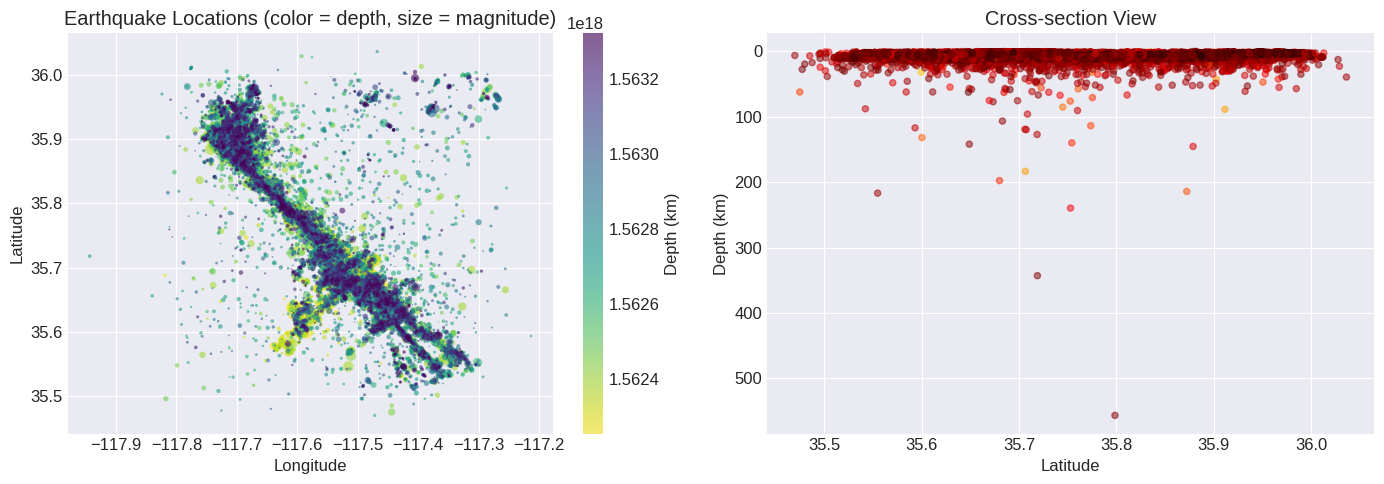

In [ ]:
# Plot the earthquake locations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Map view
scatter = axes[0].scatter(eq_data['longitude'], eq_data['latitude'],
                          c=eq_data['datetime'], s=eq_data['magnitude']**2 * 3,
                          cmap='viridis_r', alpha=0.6, edgecolors='none')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Earthquake Locations (color = depth, size = magnitude)')
plt.colorbar(scatter, ax=axes[0], label='Depth (km)')

# Depth vs Latitude
axes[1].scatter(eq_data['latitude'], eq_data['depth_km'],
                c=eq_data['magnitude'], s=20, cmap='hot', alpha=0.5)
axes[1].set_xlabel('Latitude')
axes[1].set_ylabel('Depth (km)')
axes[1].set_title('Cross-section View')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()